In [116]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import least_squares
from scipy.signal import medfilt
import imageio.v2 as imageio
from copy import deepcopy

In [157]:
class ThinFilmLayer:
    """
    Class to represent a single layer in a thin film system.
    It encapsulates the layer's index of refraction 'n', extinction coefficient 'k', 
    and thickness. n and k vary with wavelength.
    """
    
    @staticmethod
    def find_file_insensitive(path, filename):
        """
        Search for a file in the specified path in a case-insensitive manner.

        Parameters:
        path : str
            The directory path where to look for the file.
        filename : str
            The name of the file to look for.

        Returns:
        str or None
            The name of the file with the original case if found, None otherwise.
        """
        filename_lower = filename.lower()
        for file in os.listdir(path):
            if file.lower() == filename_lower:
                return file
        return None

    def __init__(self, material, thickness, n_points, min_wavelength, max_wavelength):
        """
        Initialize the layer with the chosen material's properties.
        
        Parameters:
        material : str
            Name of the material where its n, k are extracted.
        thickness : float
            Thickness of the material chosen [nm]. 
            For air and substrate, the thickness does not matter (can be set to 1, for example).
        n_points: int
            Number of points for spline fitting.
            If n_points == 0, then use all the n and k data within the wavelength range.
        min_wavelength: float
            Lower bound of the wavelength used to fit for n and k.
        max_wavelength: float
            Upper bound of the wavelength used to fit for n and k.
        """
        # Assertions to check input types
        assert isinstance(material, str), "material should be a string"
        assert isinstance(thickness, (float, int)), "thickness should be a float or int"
        assert isinstance(n_points, int), "n_points should be an integer"
        assert isinstance(min_wavelength, (float, int)), "min_wavelength should be a float or int"
        assert isinstance(max_wavelength, (float, int)), "max_wavelength should be a float or int"

        # Additional assertions for value constraints
        assert thickness >= 0, "thickness should be non-negative"
        assert n_points >= 0, "n_points should be non-negative"
        assert min_wavelength >= 0 and min_wavelength < max_wavelength, "min_wavelength should be non-negative and less than max_wavelength"
        assert max_wavelength >= 0 and max_wavelength > min_wavelength, "max_wavelength should be non-negative and greater than min_wavelength"

        self.material = material
        self.thickness = thickness
        
        # check if a file with material name exists
        path = "database_nk"
        filename = self.find_file_insensitive(path, f"{material}.csv")
        if filename is not None:
            # if yes, read the file
            data = pd.read_csv(os.path.join(path, filename))
            print(f"nk data found for {material}.")
            
            photon_energy = data.iloc[:, 0].values
            wavelength = 1239.8419843320021 / photon_energy # an array of wavelengths
            n = data.iloc[:, 1].values
            k = data.iloc[:, 2].values

            # Sort wavelength, n, and k in ascending order for spline fitting
            sorted_indices = np.argsort(wavelength)
            wavelength = wavelength[sorted_indices]
            n = n[sorted_indices]
            k = k[sorted_indices]

        else:
            # if the file does not exist, generate n and k
            wavelength = np.linspace(min_wavelength, max_wavelength, n_points)
            n = np.random.uniform(1.4, 2.0, n_points)
            k = np.random.uniform(0.0, 0.2, n_points)
            print(f"nk data not found for {material}.")

        # Filtering the data based on wavelength range before creating the spline representation
        indices = (wavelength >= min_wavelength) & (wavelength <= max_wavelength)
        wavelength = wavelength[indices]
        n = n[indices]
        k = k[indices]

        # If n_points != 0, select n points with approximately equal spacing in the wavelength range
        # (If n_points == 0, use all the data points)
        if n_points != 0:
            indices = np.round(np.linspace(0, len(wavelength) - 1, n_points)).astype(int)
            wavelength = wavelength[indices]
            n = n[indices]
            k = k[indices]

        self.wavelength = wavelength
        self.n = np.maximum(n, 0)
        self.k = np.maximum(k, 0)

        # Store deep copies of the initial values
        self.initial_n = deepcopy(self.n)
        self.initial_k = deepcopy(self.k)
        
        # Generate spline representation of n and k
        original_n_spline_cubic = CubicSpline(wavelength, self.n)
        self.n_spline_cubic = lambda x: np.maximum(original_n_spline_cubic(x), 0)

        original_k_spline_cubic = CubicSpline(wavelength, self.k)
        self.k_spline_cubic = lambda x: np.maximum(original_k_spline_cubic(x), 0)

    def get_n(self, wavelength):
        """
        Returns the index of refraction at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the index of refraction.
        """
        n_value = self.n_spline_cubic(wavelength)
        return np.maximum(n_value, 0)

    def get_k(self, wavelength):
        """
        Returns the extinction coefficient at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the extinction coefficient.
        """
        k_value = self.k_spline_cubic(wavelength)
        return np.maximum(k_value, 0)
    
    def get_N(self, wavelength):
        """
        Returns the refractive index at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the refractive index.
        """
        return self.get_n(wavelength) + 1j * self.get_k(wavelength)

    def set_n(self, wavelength, new_n_value):
        """
        Sets the refractive index at the specified wavelength and updates the spline representation.

        Parameters:
        wavelength : float
            The wavelength [nm] at which to set the index of refraction.
            It is not necessarily the exact wavelength, just need to be the wavelength that is near the point to be adjusted.
        new_n_value : float
            The new index of refraction value.
        """
        idx = (np.abs(self.wavelength - wavelength)).argmin()  # find the closest wavelength
        self.n[idx] = new_n_value
        original_n_spline_cubic = CubicSpline(self.wavelength, self.n)
        self.n_spline_cubic = lambda x: np.maximum(original_n_spline_cubic(x), 0)


    def set_k(self, wavelength, new_k_value):
        """
        Sets the extinction coefficient at the specified wavelength and updates the spline representation.
        
        Parameters:
        wavelength : float
            The wavelength [nm] at which to set the extinction coefficient.
            It is not necessarily the exact wavelength, just need to be the wavelength that is near the point to be adjusted.
        new_k_value : float
            The new extinction coefficient value.
        """
        idx = (np.abs(self.wavelength - wavelength)).argmin()  # find the closest wavelength
        self.k[idx] = new_k_value
        original_k_spline_cubic = CubicSpline(self.wavelength, self.k)
        self.k_spline_cubic = lambda x: np.maximum(original_k_spline_cubic(x), 0)

    def reset_n_k(self):
        """
        Reset the refractive index (n) and extinction coefficient (k) 
        to their original values when the instance was first created.
        """
        self.n = deepcopy(self.initial_n)
        self.k = deepcopy(self.initial_k)

    def plot_n(self, min_wavelength, max_wavelength):
        """
        Plots the index of refraction as a function of wavelength.

        Parameters:
        min_wavelength: float
            Lower bound of the wavelength used to plot n.
        max_wavelength: float
            Upper bound of the wavelength used to plot n.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        plt.figure()
        plt.plot(wavelengths, self.n_spline_cubic(wavelengths), '-', label='n spline cubic')
        plt.scatter(self.wavelength, self.n, marker='o', color='r', label='n data')
        plt.xlabel('Wavelength (λ) [nm]')
        plt.ylabel('Refractive index (n)')
        plt.title(f'Refractive index (n) vs wavelength for {self.material}')
        plt.legend()
        plt.show()

    def plot_k(self, min_wavelength, max_wavelength):
        """
        Plots the extinction coefficient as a function of wavelength.

        Parameters:
        min_wavelength: float
            Lower bound of the wavelength used to plot n.
        max_wavelength: float
            Upper bound of the wavelength used to plot n.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        plt.figure()
        plt.plot(wavelengths, self.k_spline_cubic(wavelengths), '-', label='k spline cubic')
        plt.scatter(self.wavelength, self.k, marker='o', color='r', label='k data')
        plt.xlabel('Wavelength (λ) [nm]')
        plt.ylabel('Extinction coefficient (k)')
        plt.title(f'Extinction coefficient (k) vs wavelength for {self.material}')
        plt.legend()
        plt.show()

    def plot_nk(self, min_wavelength, max_wavelength):
        """
        Plots the index of refraction and extinction coefficient as functions of wavelength,
        both for the input data and the spline interpolation.

        Parameters:
        min_wavelength: float
            Lower bound of the wavelength used to plot n and k.
        max_wavelength: float
            Upper bound of the wavelength used to plot n and k.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        n_values = self.n_spline_cubic(wavelengths)
        k_values = self.k_spline_cubic(wavelengths)

        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Wavelength (λ) [nm]')
        ax1.set_ylabel('Refractive index (n)', color='tab:blue')
        ax1.plot(wavelengths, n_values, '-', color='tab:blue', label='n spline')
        ax1.scatter(self.wavelength, self.n, marker='o', color='r', label='n data')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()  
        ax2.set_ylabel('Extinction coefficient (k)', color='tab:red')  
        ax2.plot(wavelengths, k_values, '-', color='tab:red', label='k spline')
        ax2.scatter(self.wavelength, self.k, marker='o', color='r', label='k data')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        fig.tight_layout()  
        plt.title(f'Refractive index and extinction coefficient vs wavelength for {self.material}')
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.show()



In [158]:
class FakeThinFilmLayer:
    def __init__(self, thickness, n, k):
        self.thickness = thickness
        self.n = n
        self.k = k
    
    def get_N(self, wavelength):
        return self.n + 1j * self.k

    def set_n(self, n):
        self.n = n

    def set_k(self, k):
        self.k = k

In [159]:
class ThinFilmSystem:
    """
    Class to represent a thin film system composed of multiple layers.
    """
    def __init__(self, layers):
        """
        Initialize the system with a list of ThinFilmLayer objects.
        layers : list of ThinFilmLayer
            Layers of the system in order from the top layer to the substrate.
        """
        assert isinstance(layers, list) and all(isinstance(layer, ThinFilmLayer) for layer in layers), "layers should be a list of ThinFilmLayer objects"
        self.layers = layers

    def add_layer(self, layer):
        """
        Add a layer to the system. The new layer is added to the top of the stack.

        Parameters:
        layer : ThinFilmLayer
            The layer to add. This should be an instance of the ThinFilmLayer class.
        """
        self.layers.insert(0, layer)
    
    def calculate_propagation_matrix(self, wavelength, layer_index):
        """
        Calculate the propagation matrix for this layer for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the propagation matrix of this layer.
        layer_index: int
            Index of the layer to be calculated in the multilayer system.

        Returns:
        P : 2D array
            Propagation matrix of this layer.
        """
        N = self.layers[layer_index].get_N(wavelength)
        thickness = self.layers[layer_index].thickness
        phase = 2 * np.pi * N * thickness / wavelength
        P = np.array([[np.exp(1j * phase.real) * np.exp(-phase.imag), 0], 
                      [0, np.exp(-1j * phase.real) * np.exp(phase.imag)]])
        return P
    
    def calculate_boundary_matrix(self, wavelength, layer_index):
        """
        Calculate the boundary matrix for two adjacent layers ("this" layer and "next" layer) 
        in the multilayer system for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the boundary matrix of this layer.
        layer_index: int
            Index of the layer to be calculated in the multilayer system.
        
        Returns:
        B : 2D array
            Boundary matrix of the boundary between this layer and the next layer.
        """
        N_this = self.layers[layer_index].get_N(wavelength)
        N_next = self.layers[layer_index + 1].get_N(wavelength)
        B = 1 / (2 * N_this) * np.array([[N_this + N_next, N_this - N_next],
                                         [N_this - N_next, N_this + N_next]])
        B = np.conjugate(B)
        return B
    
    def calculate_total_transfer_matrix(self, wavelength):
        """
        Calculate the total transfer matrix for the multilayer system 
        for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the transfer matrix of this layer.
        
        Returns:
        M_total : 2D array
            Total transfer matrix of the multilayer system.
        """
        M = np.eye(2) # create an identity matrix
        B01 = self.calculate_boundary_matrix(wavelength, 0) # The boundary matrix between air and the first layer
        M = M @ B01
        for index in range(1, len(self.layers) - 1):
            P = self.calculate_propagation_matrix(wavelength, index)
            B = self.calculate_boundary_matrix(wavelength, index)
            M = M @ P @ B
        return M
    
    def print_matrices(self, wavelength):
        """
        Print the boundary matrices, propagation matrices, and their multiplications for the multilayer system 
        for a particular wavelength.

        Parameter:
        wavelength: float
            Wavelength of the light at which matrices are printed.
        """
        # Print the boundary matrix between air and the first layer
        B01 = self.calculate_boundary_matrix(wavelength, 0)
        print(f"B01 = {B01}")

        # Print the matrices for the rest layers, and their multiplication
        M = np.eye(2) # create an identity matrix
        M = B01 @ M
        print(f"M = {M}")

        for index in range(1, len(self.layers) - 1):
            P = self.calculate_propagation_matrix(wavelength, index)
            print(f"P{index} = {P}")
            M = M @ P
            print(f"M = {M}")
            B = self.calculate_boundary_matrix(wavelength, index)
            print(f"B{index}{index + 1} = {B}")
            M = M @ B
            print(f"M = {M}")
            M_cal = self.calculate_total_transfer_matrix(wavelength)
            print(f"M_cal = {M_cal}")

    def print_N(self, wavelength):
        """
        Print N for each layer in the multilayer system.
        
        Parameter:
        wavelength: float
            Wavelength of the light at which N are calculated and printed.
        """
        for layer in self.layers:
            index = self.layers.index(layer)
            print(f"N_{index} = {layer.get_N(wavelength)}")

    def calculate_RTA(self, wavelength_range):
        """
        Calculate the reflectance (R), transmittance (T), and absorption (A)
        for a multilayer system as a function of wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)
        
        Parameters:
        wavelength_range : array-like
            Range of wavelengths [nm] for which R, T, A should be calculated.
        
        Returns:
        R : array-like
            Reflectance of the multilayer system for each wavelength in wavelength_range.
        T : array-like
            Transmittance of the multilayer system for each wavelength in wavelength_range.
        A : array-like
            Absorption of the multilayer system for each wavelength in wavelength_range.
        """
        R = []
        T = []
        A = []
        for wavelength in wavelength_range:
            M = self.calculate_total_transfer_matrix(wavelength)
            # Calculate R
            r = M[1, 0] / M[0, 0]
            R_value = np.abs(r)**2
            R.append(np.clip(R_value, 0, 1)) # np.clip is used to restrict the value within [0, 1]

            # Calculate T
            n0 = self.layers[0].get_n(wavelength) # n of the incident medium, which is usually air
            ns = self.layers[-1].get_n(wavelength) # n of the substrate
            t = 1 / M[0, 0]
            T_value = np.abs(t)**2 * (ns / n0) # (ns / n0) corrects for the index of the substrate
            T.append(np.clip(T_value, 0, 1))

            # Calulate A
            A_value = 1 - R[-1] - T[-1]
            A.append(np.clip(A_value, 0, 1))

        return np.array(R), np.array(T), np.array(A)
    
    def calculate_RTA_single(self, wavelength):
        """
        Calculate the reflectance (R), transmittance (T), and absorption (A)
        for a multilayer system for a single wavelength.

        Parameters:
        wavelength: float
            Wavelength of the light to calculate R, T, A.

        Returns:
        R : float
            Reflectance of the multilayer system for this wavelength.
        T : float
            Transmittance of the multilayer system for this wavelength.
        A : float
            Absorption of the multilayer system for this wavelength.
        """
        M = self.calculate_total_transfer_matrix(wavelength)
        # Calculate R
        r = M[1, 0] / M[0, 0]
        R = np.abs(r)**2
        R = np.clip(R, 0, 1) # np.clip is used to restrict the value within [0, 1]

        # Calculate T
        n0 = self.layers[0].get_n(wavelength) # n of the incident medium, which is usually air
        ns = self.layers[-1].get_n(wavelength) # n of the substrate
        t = 1 / M[0, 0]
        T = np.abs(t)**2 * (ns / n0) # (ns / n0) corrects for the index of the substrate
        T = np.clip(T, 0, 1)

        # Calculate A
        A = 1 - R - T
        A = np.clip(A, 0, 1)

        return R, T, A

    def plot_RTA(self, wavelength_range):
        """
        Plot the reflectance (R), transmittance (T), and absorption (A)
        for the multilayer system as a function of wavelength.
        Assume the incident light is normal.

        Parameters:
        wavelength_range : array-like
            Range of wavelengths [nm] for which R, T, A should be plotted.
        """
        # Calculate RTA
        R, T, A = self.calculate_RTA(wavelength_range)

        # Generate the plot
        plt.figure(figsize=(10, 6))

        plt.plot(wavelength_range, R, label='Reflectance')
        plt.plot(wavelength_range, T, label='Transmittance')
        plt.plot(wavelength_range, A, label='Absorption')

        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Magnitude')
        plt.title('RTA vs Wavelength for Thin Film System')
        plt.legend()

      wavelength  reflectance
538   380.027253     0.125604
539   380.389859     0.125666
540   380.752432     0.125789
541   381.114971     0.125974
542   381.477476     0.126220
...          ...          ...
1884  828.719235     0.088769
1885  829.016726     0.088726
1886  829.314154     0.088693
1887  829.611520     0.088671
1888  829.908822     0.088660

[1351 rows x 2 columns]


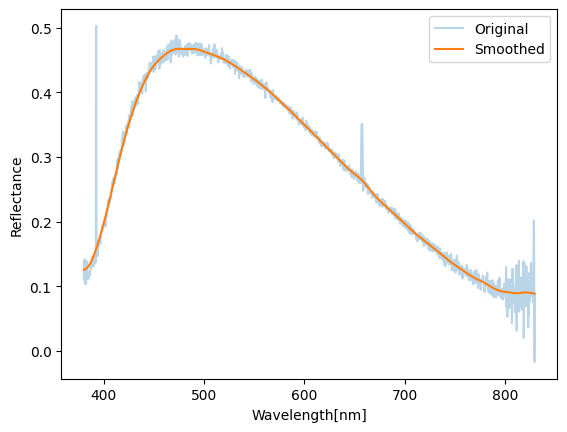

In [160]:
# Process the data (change based on the structure of the data)

l = 380 # left
r = 830 # right
wavelength_range = np.linspace(l, r, 1000)

# Load the data
path = r"test_data\spectra\+02_+05.csv"
data = pd.read_csv(path, names=['# lambda', 'reflectance', 'uncertainty', 'raw', 'dark', 'reference', 'fit'], skiprows=13)
data = data.rename(columns={'# lambda': 'wavelength'})

# Filter data based on wavelength
data = data[(data['wavelength'] >= l) & (data['wavelength'] <= r)]

# Apply the moving median filter to remove sudden spikes
kernel_size = 11 # Adjust as needed
data_without_outliers = data['reflectance']
data_without_outliers = medfilt(data['reflectance'], kernel_size=kernel_size)

# Apply a Gaussian smoothing
sigma = 20 # This is the standard deviation for the Gaussian kernel. Adjust as needed.
smoothed_reflectance = gaussian_filter1d(data_without_outliers, sigma)

# Create a smoothed panda DataFrame
smoothed_data = {
    'wavelength': data['wavelength'],
    'reflectance': smoothed_reflectance
}
smoothed_data = pd.DataFrame(smoothed_data)

plt.figure()
plt.plot(data['wavelength'], data['reflectance'], label='Original', alpha=0.3)
print(smoothed_data)
plt.plot(smoothed_data['wavelength'], smoothed_data['reflectance'], label='Smoothed')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

Thickness 1 = 104nm (calculated by least squared method)

nk data found for air.
nk data found for igzo_111.
nk data found for sio2.
nk data found for c-Si.
[380.3196271  439.66027813 520.94201022 639.09380636 826.56132289]
[2.18891476 2.10889382 2.0642569  2.03309232 2.00816669]


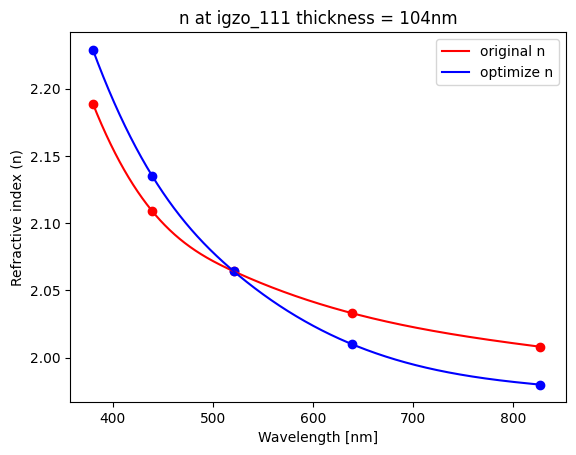

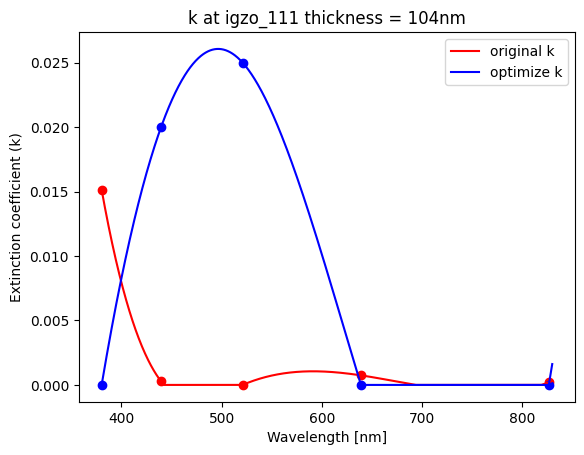

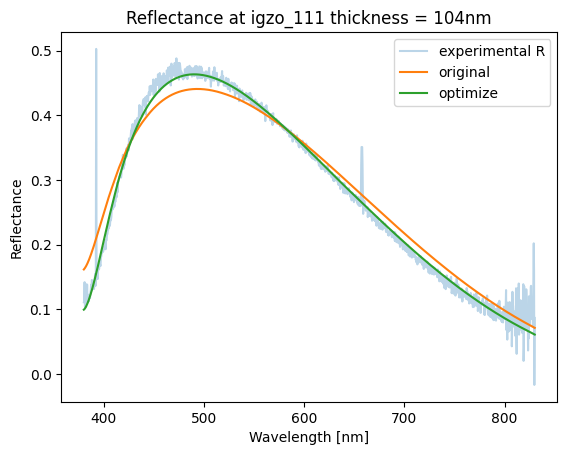

In [161]:
# Create multilayer system
air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = ThinFilmLayer("igzo_111", 104.0, 5, l, r)
layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

multilayer = ThinFilmSystem([air, layer1, layer2, substrate])
R1, _, _ = multilayer.calculate_RTA(wavelength_range)

print(layer1.wavelength)
print(layer1.n)

# Change n and plot
plt.figure()
plt.scatter(layer1.wavelength, layer1.n, c='r')
plt.plot(wavelength_range, layer1.n_spline_cubic(wavelength_range), c='r', label='original n')

layer1.set_n(380, 2.229)
layer1.set_n(439, 2.135)
layer1.set_n(639, 2.01)
layer1.set_n(826, 1.98)

plt.scatter(layer1.wavelength, layer1.n, c='b')
plt.plot(wavelength_range, layer1.n_spline_cubic(wavelength_range), c='b', label='optimize n')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index (n)')
plt.legend()
plt.title('n at igzo_111 thickness = 104nm')
plt.savefig('n at 104nm.png', dpi=300)
plt.show()

# Change k and plot
plt.figure()
plt.scatter(layer1.wavelength, layer1.k, c='r')
plt.plot(wavelength_range, layer1.k_spline_cubic(wavelength_range), c='r', label='original k')

layer1.set_k(380, 0)
layer1.set_k(439, 0.02)
layer1.set_k(520, 0.025)
layer1.set_k(639, 0)
layer1.set_k(826, 0)

plt.scatter(layer1.wavelength, layer1.k, c='b')
plt.plot(wavelength_range, layer1.k_spline_cubic(wavelength_range), c='b', label='optimize k')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Extinction coefficient (k)')
plt.legend()
plt.title('k at igzo_111 thickness = 104nm')
plt.savefig('k at 104nm.png', dpi=300)
plt.show()

# Calculate and plot reflectance
R2, _, _ = multilayer.calculate_RTA(wavelength_range)

plt.figure()
plt.plot(data['wavelength'], data['reflectance'], label='experimental R', alpha=0.3)
plt.plot(wavelength_range, R1, label='original')
plt.plot(wavelength_range, R2, label='optimize')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.title('Reflectance at igzo_111 thickness = 104nm')
plt.savefig('Reflectance at 104nm.png', dpi=300)
plt.show()


Thickness 2 = 100nm

nk data found for air.
nk data found for igzo_111.
nk data found for sio2.
nk data found for c-Si.
[380.3196271  439.66027813 520.94201022 639.09380636 826.56132289]
[2.18891476 2.10889382 2.0642569  2.03309232 2.00816669]


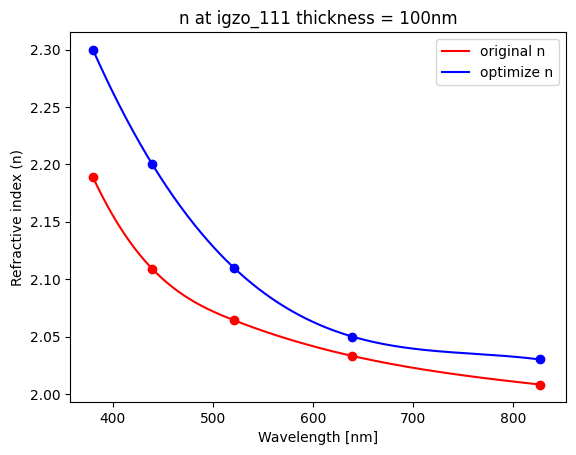

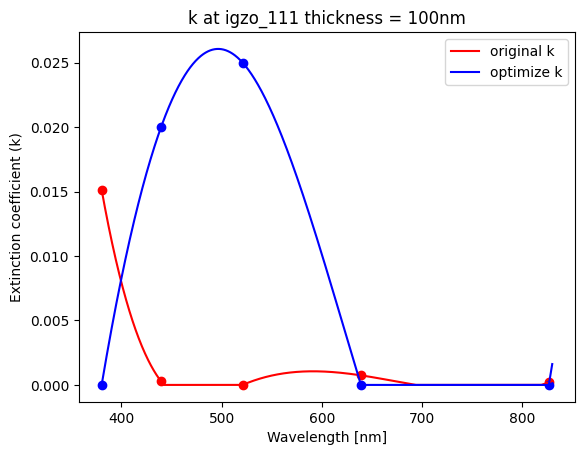

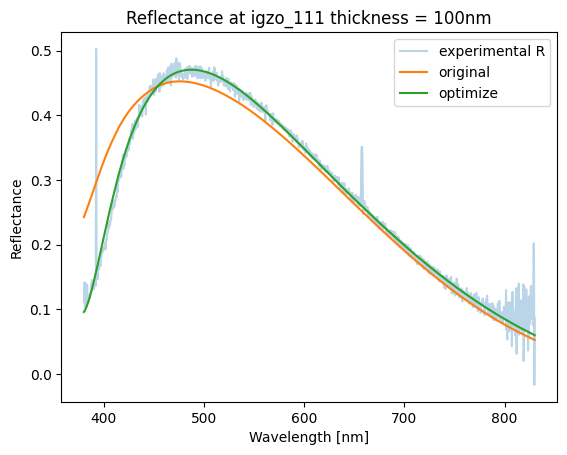

In [162]:
# Create multilayer system
air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = ThinFilmLayer("igzo_111", 100.0, 5, l, r)
layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

multilayer = ThinFilmSystem([air, layer1, layer2, substrate])
R1, _, _ = multilayer.calculate_RTA(wavelength_range)

print(layer1.wavelength)
print(layer1.n)

# Change n and plot
plt.figure()
plt.scatter(layer1.wavelength, layer1.n, c='r')
plt.plot(wavelength_range, layer1.n_spline_cubic(wavelength_range), c='r', label='original n')

layer1.set_n(380, 2.3)
layer1.set_n(439, 2.2)
layer1.set_n(520, 2.11)
layer1.set_n(639, 2.05)
layer1.set_n(826, 2.03)

plt.scatter(layer1.wavelength, layer1.n, c='b')
plt.plot(wavelength_range, layer1.n_spline_cubic(wavelength_range), c='b', label='optimize n')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index (n)')
plt.legend()
plt.title('n at igzo_111 thickness = 100nm')
plt.savefig('n at 100nm.png', dpi=300)
plt.show()

# Change k and plot
plt.figure()
plt.scatter(layer1.wavelength, layer1.k, c='r')
plt.plot(wavelength_range, layer1.k_spline_cubic(wavelength_range), c='r', label='original k')

layer1.set_k(380, 0)
layer1.set_k(439, 0.02)
layer1.set_k(520, 0.025)
layer1.set_k(639, 0)
layer1.set_k(826, 0)

plt.scatter(layer1.wavelength, layer1.k, c='b')
plt.plot(wavelength_range, layer1.k_spline_cubic(wavelength_range), c='b', label='optimize k')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Extinction coefficient (k)')
plt.legend()
plt.title('k at igzo_111 thickness = 100nm')
plt.savefig('k at 100nm.png', dpi=300)
plt.show()

# Calculate and plot reflectance
R2, _, _ = multilayer.calculate_RTA(wavelength_range)

plt.figure()
plt.plot(data['wavelength'], data['reflectance'], label='experimental R', alpha=0.3)
plt.plot(wavelength_range, R1, label='original')
plt.plot(wavelength_range, R2, label='optimize')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.title('Reflectance at igzo_111 thickness = 100nm')
plt.savefig('Reflectance at 100nm.png', dpi=300)
plt.show()


Thickness 3 = 108nm

nk data found for air.
nk data found for igzo_111.
nk data found for sio2.
nk data found for c-Si.
[380.3196271  439.66027813 520.94201022 639.09380636 826.56132289]
[2.18891476 2.10889382 2.0642569  2.03309232 2.00816669]


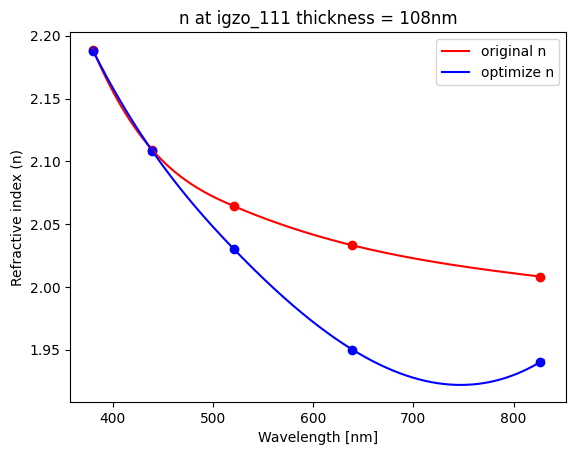

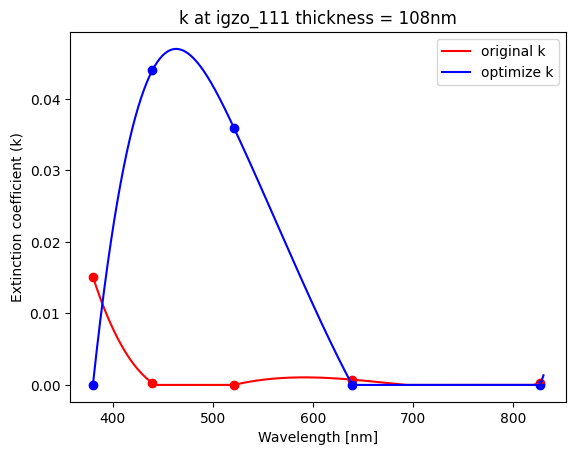

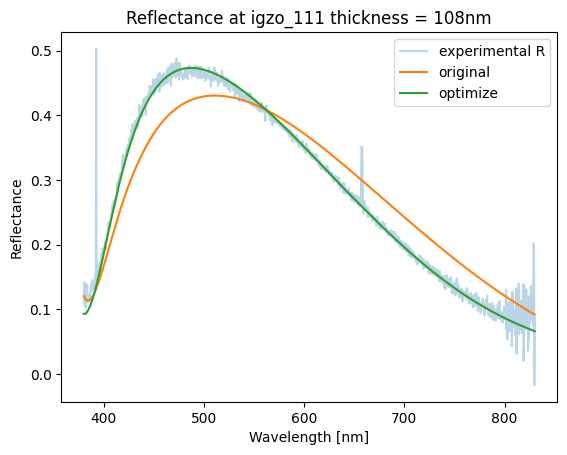

In [163]:
# Create multilayer system
air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = ThinFilmLayer("igzo_111", 108.0, 5, l, r)
layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

multilayer = ThinFilmSystem([air, layer1, layer2, substrate])
R1, _, _ = multilayer.calculate_RTA(wavelength_range)

print(layer1.wavelength)
print(layer1.n)

# Change n and plot
plt.figure()
plt.scatter(layer1.wavelength, layer1.n, c='r')
plt.plot(wavelength_range, layer1.n_spline_cubic(wavelength_range), c='r', label='original n')

layer1.n = [2.188, 2.108, 2.03, 1.95, 1.94] # Change the n values of the 5 points
layer1.n_spline_cubic = CubicSpline(layer1.wavelength, layer1.n) # Do cubicspline
# Below do the same as above:
# layer1.set_n(520, 2.03)
# layer1.set_n(639, 1.95)
# layer1.set_n(826, 1.94)

plt.scatter(layer1.wavelength, layer1.n, c='b')
plt.plot(wavelength_range, layer1.n_spline_cubic(wavelength_range), c='b', label='optimize n')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index (n)')
plt.legend()
plt.title('n at igzo_111 thickness = 108nm')
plt.savefig('n at 108nm.png', dpi=300)
plt.show()

# Change k and plot
plt.figure()
plt.scatter(layer1.wavelength, layer1.k, c='r')
plt.plot(wavelength_range, layer1.k_spline_cubic(wavelength_range), c='r', label='original k')

layer1.set_k(380, 0)
layer1.set_k(439, 0.044)
layer1.set_k(520, 0.036)
layer1.set_k(639, 0)
layer1.set_k(826, 0)

plt.scatter(layer1.wavelength, layer1.k, c='b')
plt.plot(wavelength_range, layer1.k_spline_cubic(wavelength_range), c='b', label='optimize k')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Extinction coefficient (k)')
plt.legend()
plt.title('k at igzo_111 thickness = 108nm')
plt.savefig('k at 108nm.png', dpi=300)
plt.show()

# Calculate and plot reflectance
R2, _, _ = multilayer.calculate_RTA(wavelength_range)

plt.figure()
plt.plot(data['wavelength'], data['reflectance'], label='experimental R', alpha=0.3)
plt.plot(wavelength_range, R1, label='original')
plt.plot(wavelength_range, R2, label='optimize')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.title('Reflectance at igzo_111 thickness = 108nm')
plt.savefig('Reflectance at 108nm.png', dpi=300)
plt.show()


Use Levenburg-Marquardt algorithm to find the solution

In [164]:
print(layer1.n)
print(layer1.k)

[2.188, 2.108, 2.03, 1.95, 1.94]
[0.    0.044 0.036 0.    0.   ]


nk data found for air.
nk data found for igzo_111.
nk data found for sio2.
nk data found for c-Si.


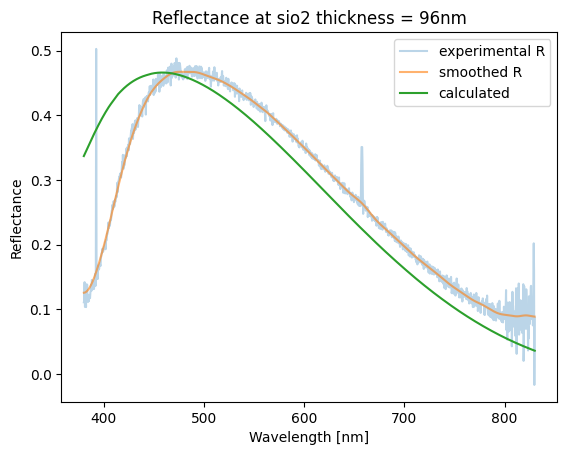

In [165]:
# params = [n1, n2, n3, n4, n5, k1, k2, k3, k4, k5, t]
# wavelength = [w1, w2, w3, w4, w5]

def residuals(params, multilayer, layer_index, data):
    """
    Calculate the residuals between calculated reflectance and experimental reflectance.

    **Parameters:**
    params: list of float
        List of parameters [n1, n2, n3, n4, n5, k1, k2, k3, k4, k5, thickness] to be optimized.

    multilayer: ThinFilmSystem
        A ThinFilmSystem to calculate the reflectance.

    layer_index: int
        The index of the layer whose parameters are to be optimized.

    data: pandas DataFrame
        Experimental data where data['wavelength'] is the wavelength, and data['reflectance'] is the experimental reflectance.

    **Returns:**
    residual: list of float
        residuals = calculated_reflectance - experimental_reflectance.
    """
    # Extract spline control points and thickness from params
    n_control = params[:5]
    k_control = params[5:10]
    thickness = params[10]

    # Create cubic splines for n and k
    wavelength = multilayer.layers[layer_index].wavelength
    multilayer.layers[layer_index].n_spline_cubic = CubicSpline(wavelength, n_control)
    multilayer.layers[layer_index].k_spline_cubic = CubicSpline(wavelength, k_control)
    multilayer.layers[layer_index].thickness = thickness
    
    # Calculate the residuals
    wavelength_range = data['wavelength']
    model_reflectance, _, _ = multilayer.calculate_RTA(wavelength_range)
    experimental_reflectance = data['reflectance']
    residuals = model_reflectance - experimental_reflectance

    return residuals

# Create multilayer system
air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = ThinFilmLayer("igzo_111", 96, 5, l, r)
layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

multilayer1 = ThinFilmSystem([air, layer1, layer2, substrate])

R_calculated, _, _ = multilayer1.calculate_RTA(wavelength_range)
plt.figure()
plt.plot(data['wavelength'], data['reflectance'], label='experimental R', alpha=0.3)
plt.plot(smoothed_data['wavelength'], smoothed_data['reflectance'], label='smoothed R', alpha=0.6)
plt.plot(wavelength_range, R_calculated, label='calculated')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at sio2 thickness = {layer1.thickness}nm')
# plt.savefig(f'Reflectance at {optimized_params[10]}nm.png', dpi=300)
plt.show()

In [166]:
# Optimization
initial_n = layer1.initial_n # [n1, n2, n3, n4, n5]
initial_k = layer1.initial_k # [k1, k2, k3, k4, k5]
initial_thickness = layer1.thickness
initial_params = [*initial_n, *initial_k, initial_thickness] # the * syntax unpacks the elements of the lists
# bounds for n, k, and thickness
lower_bounds = [0]*5 + [0]*5 + [0]  # non-negative bounds for n, k, and thickness
upper_bounds = [3]*5 + [3]*5 + [1000]  # arbitrary upper bounds, adjust as necessary

result = least_squares(residuals, initial_params, args=(multilayer1, 1, smoothed_data), bounds=(lower_bounds, upper_bounds))

optimized_params = result.x
print("Optimized control points for n:", optimized_params[:5])
print("Optimized control points for k:", optimized_params[5:10])
print("Optimized thickness:", optimized_params[10])

Optimized control points for n: [2.04964393 1.98275382 1.83707222 1.73206828 1.87966991]
Optimized control points for k: [8.45157055e-03 5.31988887e-02 4.35644896e-02 1.78440819e-01
 9.89251764e-19]
Optimized thickness: 117.29676694912804


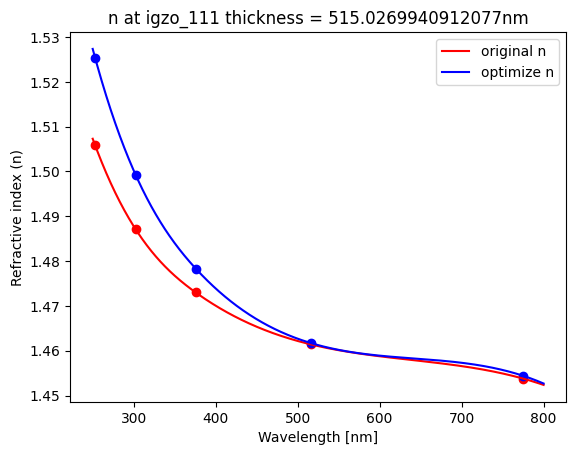

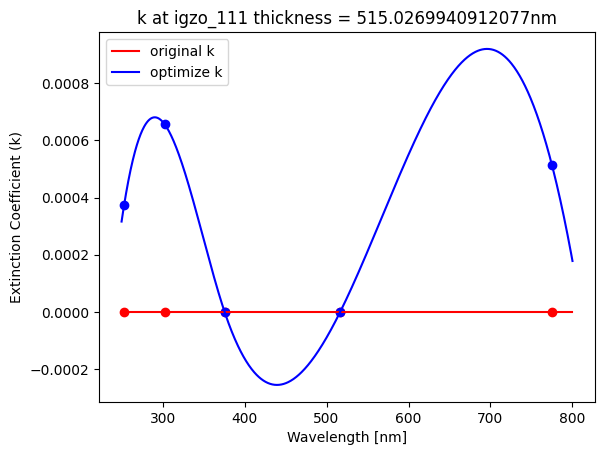

[1.52529555 1.49922841 1.47832911 1.46169275 1.45442649]


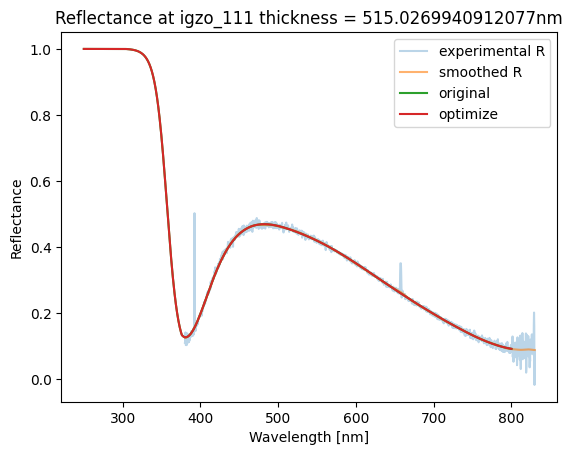

In [172]:
# Plot the result

# Plot n
plt.figure()
plt.scatter(layer1.wavelength, layer1.initial_n, c='r')
n_spline_cubic_original = CubicSpline(layer1.wavelength, layer1.initial_n)
plt.plot(wavelength_range, n_spline_cubic_original(wavelength_range), c='r', label='original n')
plt.scatter(layer1.wavelength, optimized_params[:5], c='b')
n_spline_cubic_optimized = CubicSpline(layer1.wavelength, optimized_params[:5])
plt.plot(wavelength_range, n_spline_cubic_optimized(wavelength_range), c='b', label='optimize n')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index (n)')
plt.legend()
plt.title(f'n at igzo_111 thickness = {optimized_params[10]}nm')
plt.savefig(f'n at {optimized_params[10]}nm.png', dpi=300)
plt.show()

# Plot k
plt.figure()
plt.scatter(layer1.wavelength, layer1.initial_k, c='r')
k_spline_cubic_original = CubicSpline(layer1.wavelength, layer1.initial_k)
plt.plot(wavelength_range, k_spline_cubic_original(wavelength_range), c='r', label='original k')
plt.scatter(layer1.wavelength, optimized_params[5:10], c='b')
k_spline_cubic_optimized = CubicSpline(layer1.wavelength, optimized_params[5:10])
plt.plot(wavelength_range, k_spline_cubic_optimized(wavelength_range), c='b', label='optimize k')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Extinction Coefficient (k)')
plt.legend()
plt.title(f'k at igzo_111 thickness = {optimized_params[10]}nm')
plt.savefig(f'k at {optimized_params[10]}nm.png', dpi=300)
plt.show()

# Plot reflectance
layer1.thickness = optimized_params[10]
R_original, _, _ = multilayer1.calculate_RTA(wavelength_range)

layer1.n = optimized_params[:5]
layer1.k = optimized_params[5:10]
print(layer1.n)

R_optimized, _, _ = multilayer1.calculate_RTA(wavelength_range)
plt.figure()
plt.plot(data['wavelength'], data['reflectance'], label='experimental R', alpha=0.3)
plt.plot(smoothed_data['wavelength'], smoothed_data['reflectance'], label='smoothed R', alpha=0.6)
plt.plot(wavelength_range, R_original, label='original')
plt.plot(wavelength_range, R_optimized, label='optimize')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at igzo_111 thickness = {optimized_params[10]}nm')
plt.savefig(f'Reflectance at {optimized_params[10]}nm.png', dpi=300)
plt.show()


Try for a single sio2 layer on si substrate

In [168]:
# Use another data2

l = 250 # left
r = 800 # right
wavelength_range = np.linspace(l, r, 1000)

# Load the data2
path = r"test_data\sio2_reflectance_test.csv"
data2 = pd.read_csv(path, names=['# lambda', 'reflectance', 'uncertainty', 'raw', 'dark', 'reference', 'fit'], skiprows=13)
data2 = data2.rename(columns={'# lambda': 'wavelength'})

# Filter data2 based on wavelength
data2 = data2[(data2['wavelength'] >= l) & (data2['wavelength'] <= r)]

# Apply the moving median filter to remove sudden spikes
kernel_size = 11 # Adjust as needed
data_without_outliers = data2['reflectance']
data_without_outliers = medfilt(data2['reflectance'], kernel_size=kernel_size)

nk data found for air.
nk data found for sio2.
nk data found for c-Si.


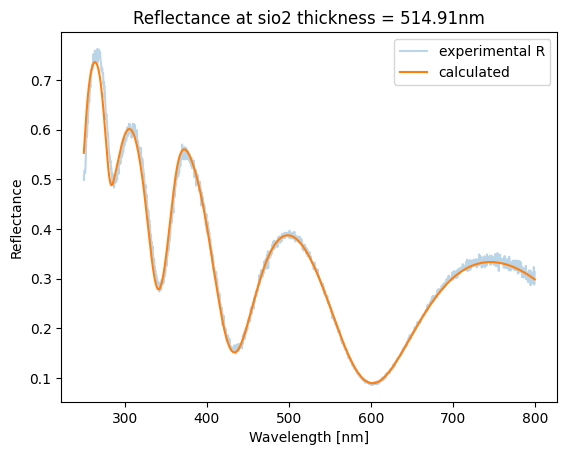

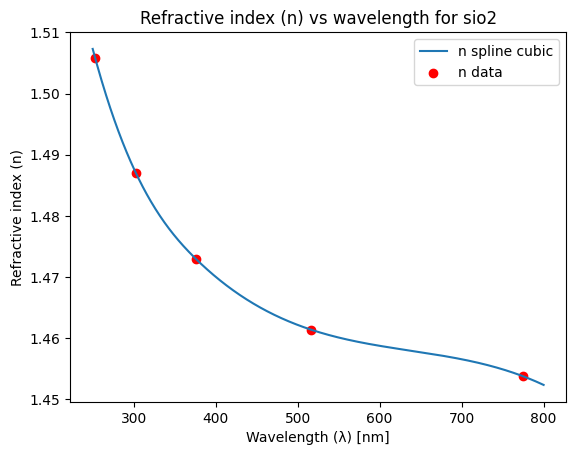

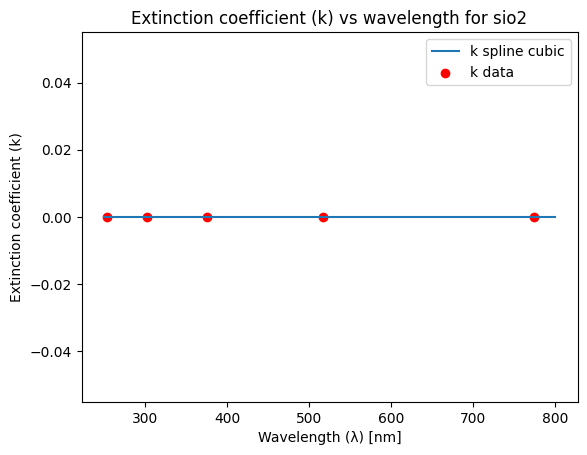

In [169]:
# Create new multilayers
air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = ThinFilmLayer("sio2", 514.91, 5, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)
multilayer2 = ThinFilmSystem([air, layer1, substrate])

# Plot reflectance
R_calculated, _, _ = multilayer2.calculate_RTA(wavelength_range)

plt.figure()
plt.plot(data2['wavelength'], data2['reflectance'], label='experimental R', alpha=0.3)
plt.plot(wavelength_range, R_calculated, label='calculated')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at sio2 thickness = {layer1.thickness}nm')
# plt.savefig(f'Reflectance at {optimized_params[10]}nm.png', dpi=300)
plt.show()

layer1.plot_n(l, r)
layer1.plot_k(l, r)


In [170]:
# Optimization
initial_n = layer1.initial_n
initial_k = layer1.initial_k
initial_thickness = layer1.thickness
initial_params = [*initial_n, *initial_k, initial_thickness] # the * syntax unpacks the elements of the lists
# bounds for n, k, and thickness
lower_bounds = [0]*5 + [0]*5 + [0]  # non-negative bounds for n, k, and thickness
upper_bounds = [3]*5 + [3]*5 + [1000]  # arbitrary upper bounds, adjust as necessary
result = least_squares(residuals, initial_params, args=(multilayer2, 1, data2), bounds=(lower_bounds, upper_bounds))
optimized_params = result.x
print("Optimized control points for n:", optimized_params[:5])
print("Optimized control points for k:", optimized_params[5:10])
print("Optimized thickness:", optimized_params[10])

Optimized control points for n: [1.52529555 1.49922841 1.47832911 1.46169275 1.45442649]
Optimized control points for k: [3.72781173e-04 6.56335642e-04 4.53791502e-26 8.02406111e-22
 5.14036007e-04]
Optimized thickness: 515.0269940912077


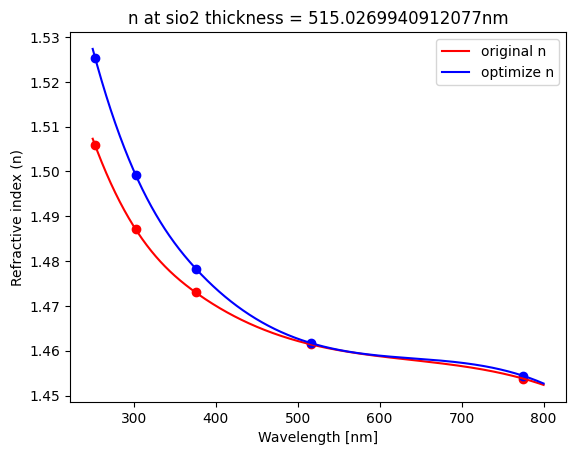

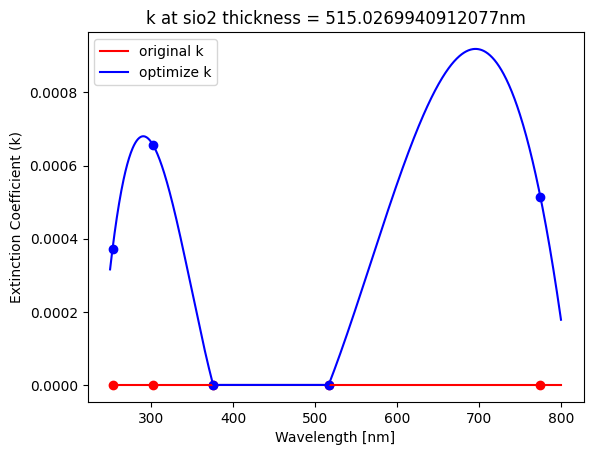

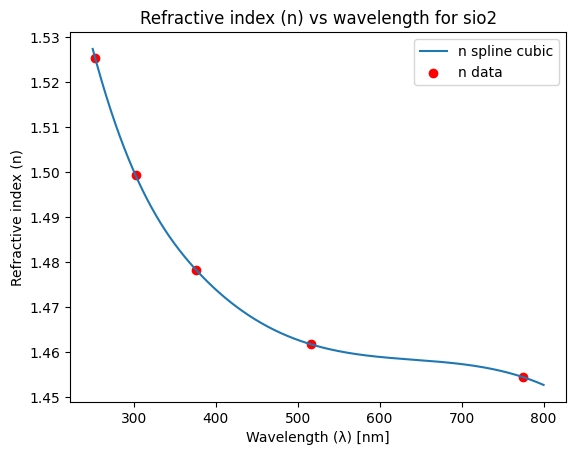

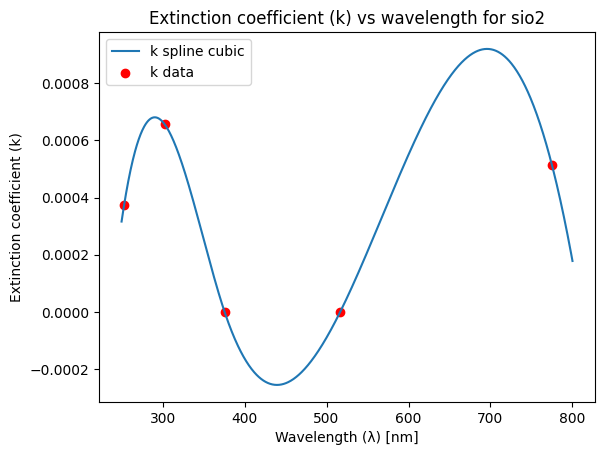

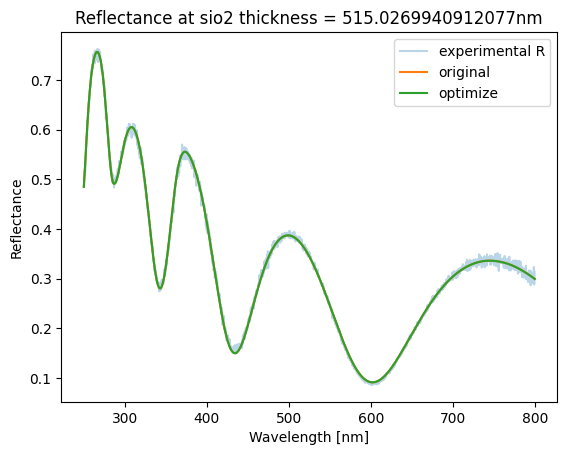

In [171]:
# Plot n
plt.figure()
plt.scatter(layer1.wavelength, layer1.initial_n, c='r')
n_spline_cubic_original = CubicSpline(layer1.wavelength, layer1.initial_n)
plt.plot(wavelength_range, n_spline_cubic_original(wavelength_range), c='r', label='original n')
plt.scatter(layer1.wavelength, optimized_params[:5], c='b')
n_spline_cubic_optimized = CubicSpline(layer1.wavelength, optimized_params[:5])
plt.plot(wavelength_range, n_spline_cubic_optimized(wavelength_range), c='b', label='optimize n')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive index (n)')
plt.legend()
plt.title(f'n at sio2 thickness = {optimized_params[10]}nm')
plt.savefig(f'n at {optimized_params[10]}nm.png', dpi=300)
plt.show()

# Plot k
plt.figure()
plt.scatter(layer1.wavelength, layer1.initial_k, c='r')
k_spline_cubic_original = CubicSpline(layer1.wavelength, layer1.initial_k)
k_spline_cubic_original = np.maximum(k_spline_cubic_original(wavelength_range), 0)
plt.plot(wavelength_range, k_spline_cubic_original, c='r', label='original k')
plt.scatter(layer1.wavelength, optimized_params[5:10], c='b')
k_spline_cubic_optimized = CubicSpline(layer1.wavelength, optimized_params[5:10])
k_spline_cubic_optimized = np.maximum(k_spline_cubic_optimized(wavelength_range), 0)
plt.plot(wavelength_range, k_spline_cubic_optimized, c='b', label='optimize k')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Extinction Coefficient (k)')
plt.legend()
plt.title(f'k at sio2 thickness = {optimized_params[10]}nm')
plt.savefig(f'k at {optimized_params[10]}nm.png', dpi=300)
plt.show()

# Plot reflectance
layer1.thickness = optimized_params[10]
R_original, _, _ = multilayer2.calculate_RTA(wavelength_range)
layer1.n = optimized_params[:5]
layer1.k = optimized_params[5:10]
layer1.plot_n(l, r)
layer1.plot_k(l, r)
R_optimized, _, _ = multilayer2.calculate_RTA(wavelength_range)
plt.figure()
plt.plot(data2['wavelength'], data2['reflectance'], label='experimental R', alpha=0.3)
plt.plot(wavelength_range, R_original, label='original')
plt.plot(wavelength_range, R_optimized, label='optimize')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Reflectance at sio2 thickness = {optimized_params[10]}nm')
plt.savefig(f'Reflectance at {optimized_params[10]}nm.png', dpi=300)
plt.show()